# 3) Neural Networks versus Decision Trees

In [68]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import numpy as np
import tensorflow as tf
import xgboost as xgb
import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, Activation
from keras import layers
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.preprocessing import StandardScaler

import os
import sys

dep_dir = os.path.abspath('dep/')
sys.path.append(dep_dir)

from plotting import plot_model_history
from roc_helper import plot_roc

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [54]:
data = fetch_openml("miniboone", parser="auto", version=1)
X, y = data["data"].values, (data["target"].values == "True").astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [3]:
p_features = data.feature_names
p_param = {
    "objective": "binary:logistic",  # or your desired objective
    "eval_metric": "error",  # Evaluation metric, e.g., logloss
    "learning_rate": 0.1,  # Learning rate
    "max_depth": 10,  # Maximum depth of trees
    "subsample": 0.8,  # Subsampling ratio
    "colsample_bytree": 0.8,  # Feature sampling ratio
    "n_estimators": 100,  # Number of boosting rounds
    "seed": 42,  # Random seed for reproducibility
    "missing": -999.0 # checked the min values 
}

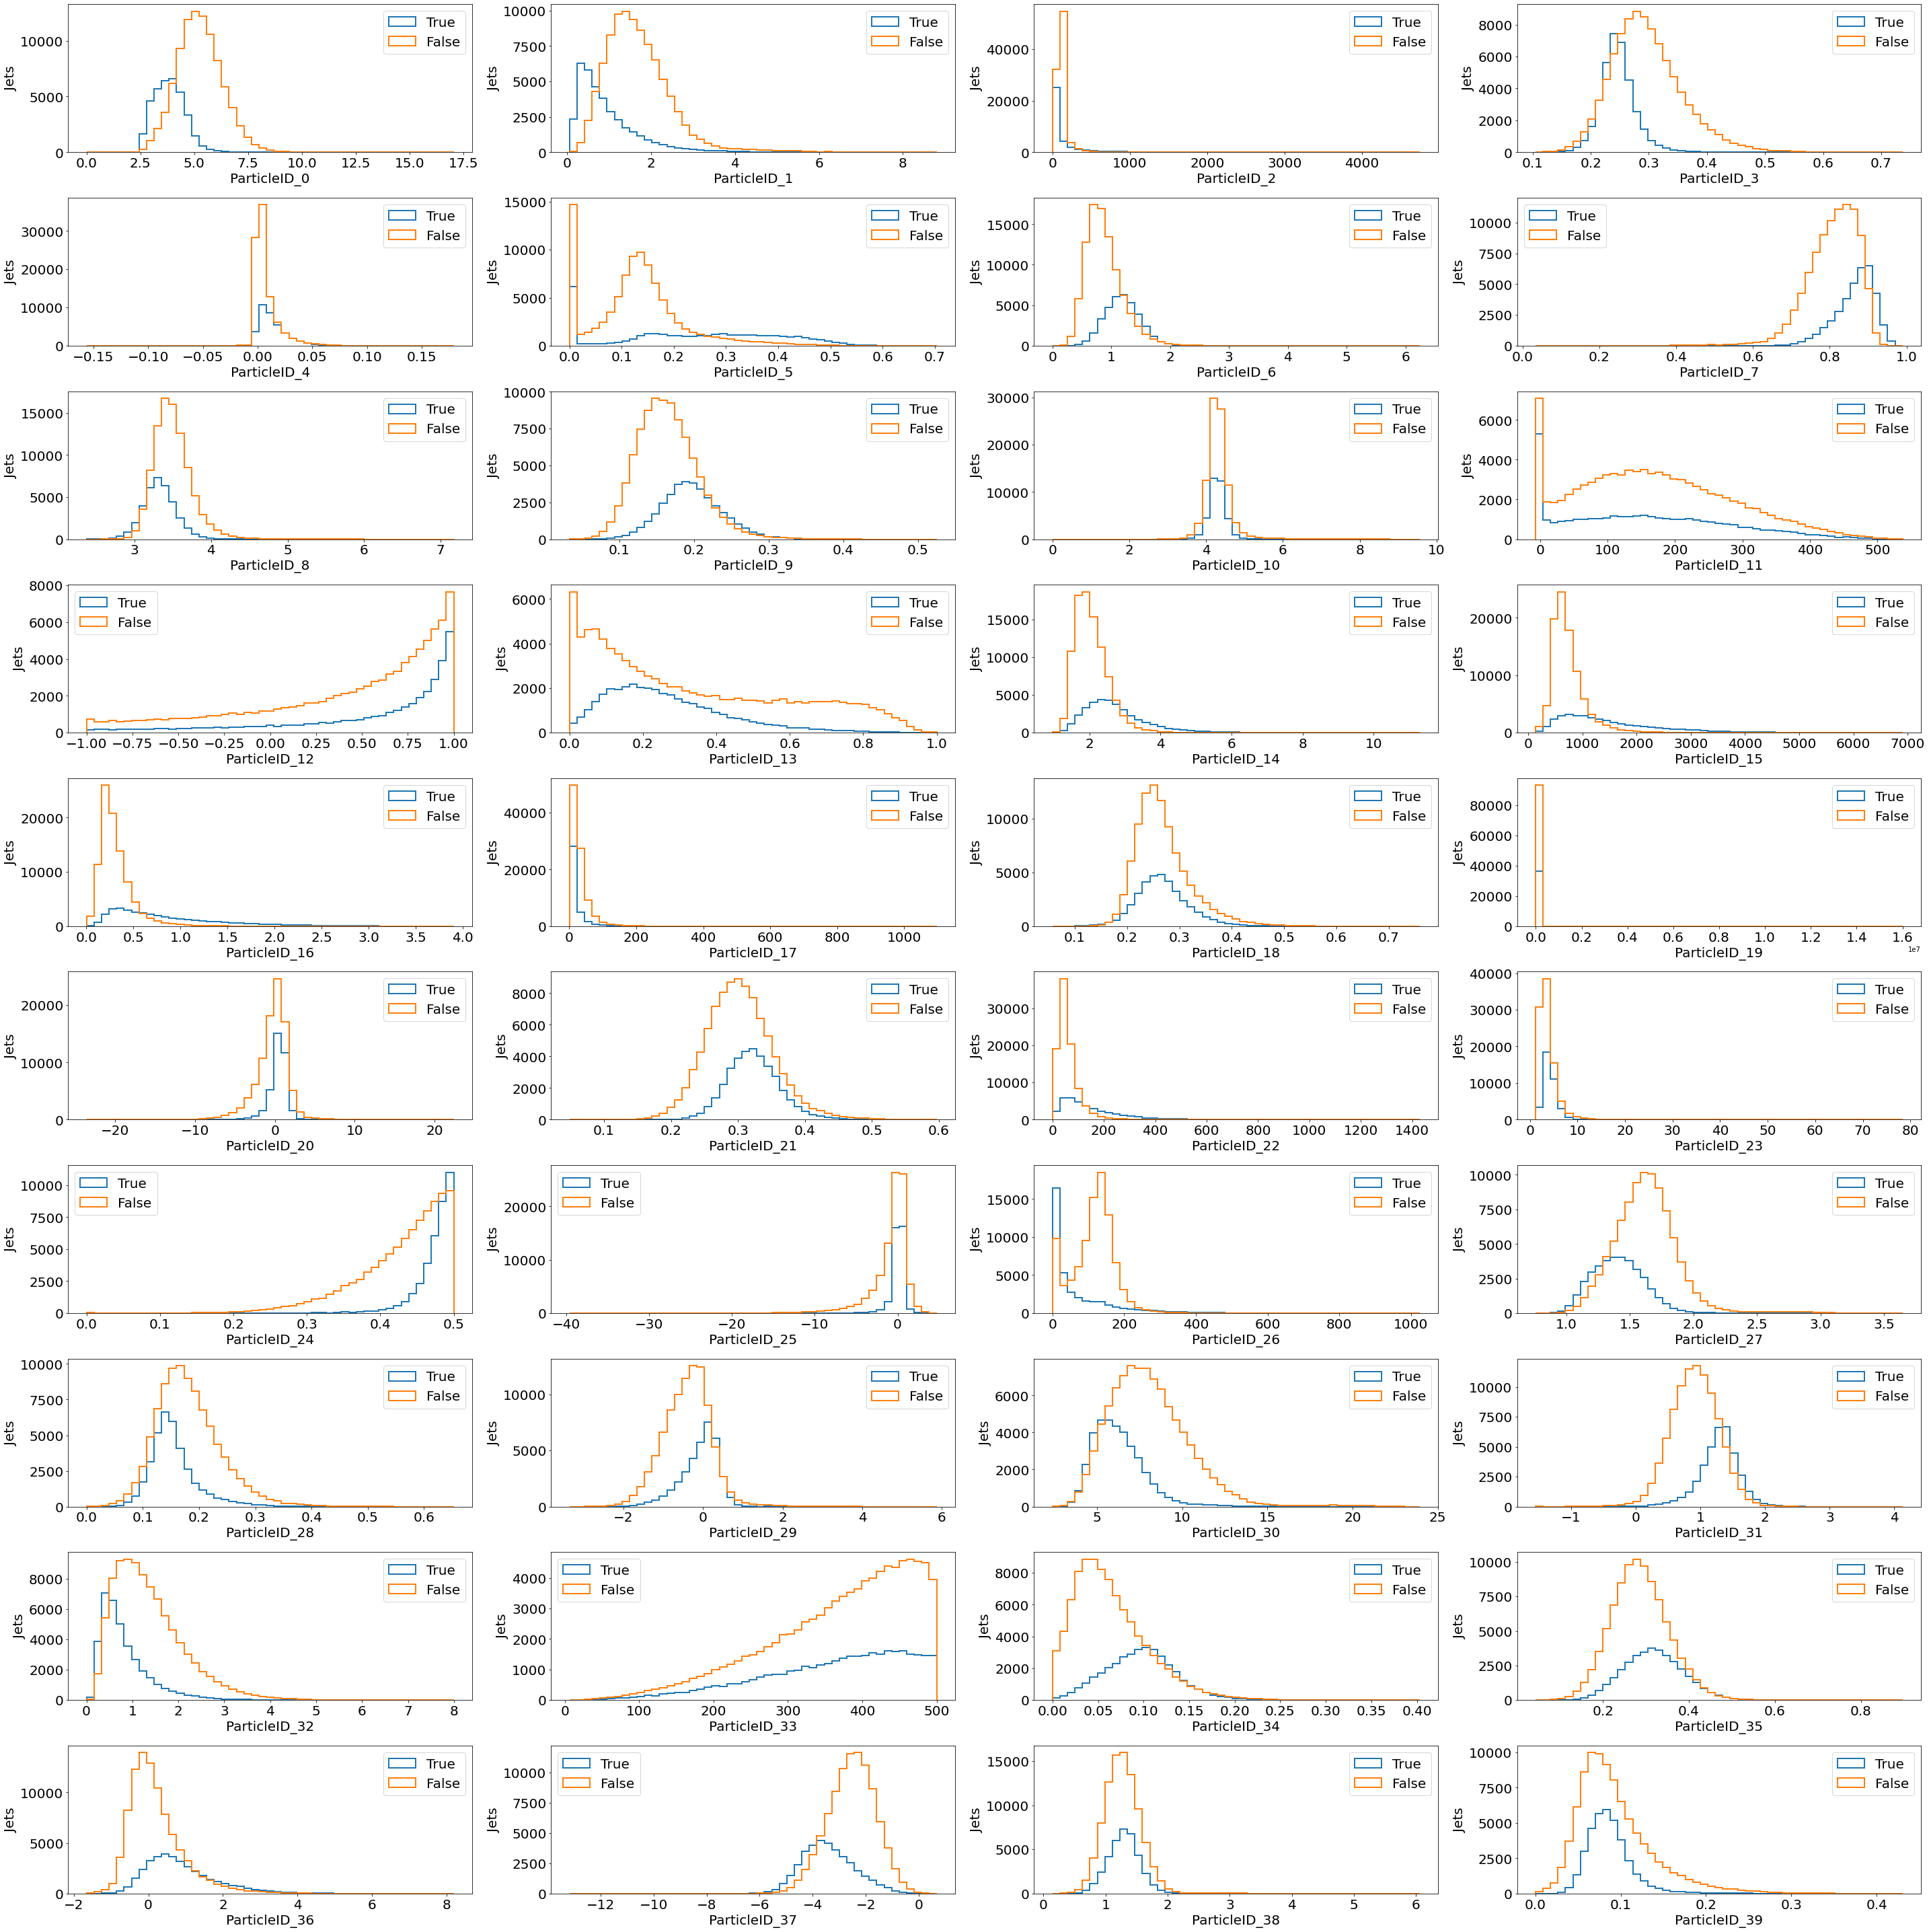

In [71]:
fig, axs = plt.subplots(10, 4, figsize=(40, 40))


for ix, ax in enumerate(axs.reshape(-1)):
    feat =  p_features[ix]
    new_X = data['frame'][feat]
    new_X = new_X[new_X != -999.0]
    new_y = data['frame']['signal']
    bins = np.linspace(np.min(new_X),np.max(new_X), 50)
    for c in data['frame']['signal'].dtype.categories:
        ax.hist(new_X[new_y == c], bins=bins, histtype="step", label=c, lw=2)
    ax.set_xlabel(feat, fontsize=20)
    ax.set_ylabel("Jets", fontsize=20)
    ax.tick_params(axis="both", which="major", labelsize=20)
    ax.legend(fontsize=20, loc="best")
plt.tight_layout()
plt.show()

## Problem A

**AUC = 98.54%** and **acc = 94.53%**

In [4]:
bdt = XGBClassifier(**p_param)

p_booster = bdt.fit(X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False)

# print(p_booster.evals_result())

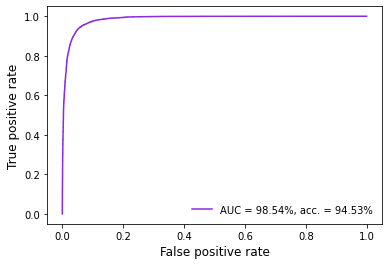

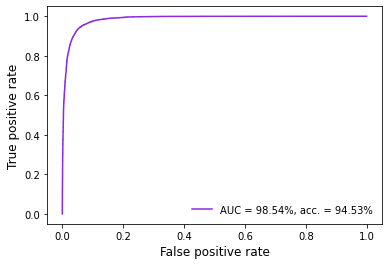

In [5]:
# # retrieve predictions and take index [:, 1] corresponding to signal
preds_bdt = p_booster.predict_proba(X_test)[:, 1]

plot_roc(y_test, preds_bdt)

## Problem B

most important feature is **f12** (ie 'ParticleID_12')

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

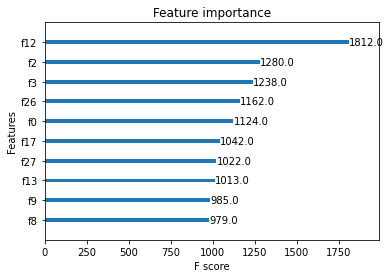

In [6]:
xgb.plot_importance(p_booster, grid=False, max_num_features=10)

In [7]:
labels = data['frame']['signal'].map({'False':False, 'True':True}).astype(bool)
data_plot = data['frame']['ParticleID_12'][labels]


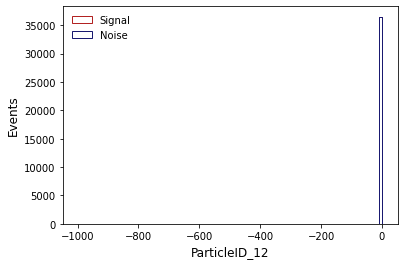

In [8]:
plt.figure()
plt.hist(
        data_plot,
        bins = np.linspace(data_plot.min(), data_plot.max(), 100),
        histtype='step',
        color='firebrick',
        label='Signal'
        )
plt.hist(
        data_plot,
        bins = np.linspace(data_plot.min(), data_plot.max(), 100),
        histtype='step',
        color='midnightblue',
        label='Noise'
)
plt.xlabel("ParticleID_12", fontsize=12)
plt.ylabel("Events", fontsize=12)
plt.legend(frameon=False)
plt.show()

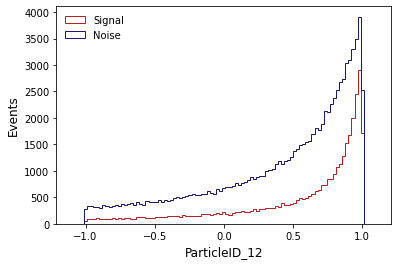

In [43]:
plt.figure()
plt.hist(
        data['frame']['ParticleID_12'][labels],
        bins = np.linspace(-1.1, 1.1, 100),
        histtype='step',
        color='firebrick',
        label='Signal'
        )
plt.hist(
        data['frame']['ParticleID_12'][~labels],
        bins = np.linspace(-1.1, 1.1, 100),
        histtype='step',
        color='midnightblue',
        label='Noise'
)
plt.xlabel("ParticleID_12", fontsize=12)
plt.ylabel("Events", fontsize=12)
plt.legend(frameon=False)
plt.show()

- clearly letting the histogram go from the minimum of the data-point to the maximum is not a good idea. This is because the minimum of the dataset is the missing value number -999.0. Since adding it to the model compilation DOES NOT remove it. I also plotted it from 0 to 1 which is the reasonable range for the dataset.

- What stood out to me was that the signal to noise ratio is pretty large (seems that there are around twice as many background events compared to actual signal). 

## Problem C

- 3 hidden layers
- 128 units each
- tanh activation
- final sigmoid activation
- binary crossentropy as loss?
- SGD optimizer (learning_rate = 0.01 the default)
- batch size 128
- 50 epochs

**OUT OF THE BOX** **AUC = 92.33%** and **acc = 87.01%**

From the plot of learning curve we can see that the model has a fairly small loss function from the get-go, and does not really seem to learn because of the oscillatory behaviour. They are pretty small oscillations though (the y scale limits are close together)

In [4]:
inputs = Input(shape=X_train.shape[1:])
dense = Dense(128, activation='tanh')
x = dense(inputs)
x = Dense(128, activation='tanh')(x)
x = Dense(128, activation='tanh')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=outputs, name='myfirstmodel')

model.summary()

Model: "myfirstmodel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,681 (155.00 KB)

 Trainable params: 39,681 (155.00 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)


In [5]:
model.compile(optimizer=SGD(learning_rate=0.01), loss=['binary_crossentropy'], metrics=['accuracy'])

In [6]:
history = model.fit(X_train, y_train, epochs=50, batch_size=128, verbose=False, validation_split=0.25)

In [7]:
preds_nn = model.predict(X_test)

813/813 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


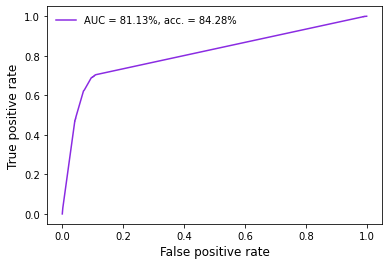

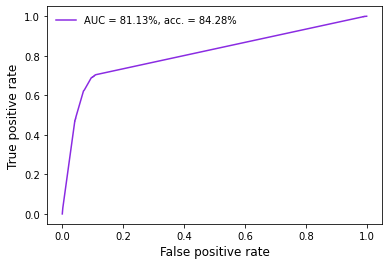

In [8]:
plot_roc(y_test, preds_nn)

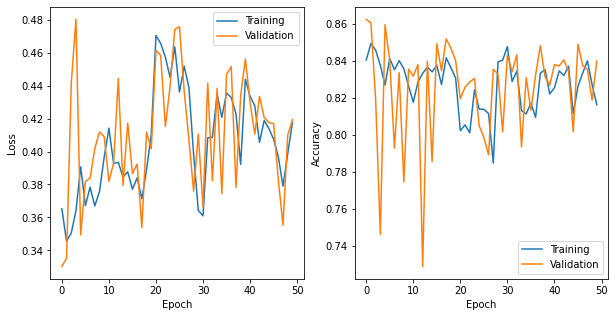

In [9]:
plot_model_history(history)

## Problem D - ReLU activations

Based on the previous exercises, it seems that the a lot of the data has negative values, and since ReLU outputs 0 for values less than 0 it kills the neurons. You can't really learn much with dead neurons. Tanh handles negative values as inputs.

In [10]:
relu_inputs = Input(shape=X_train.shape[1:])
relu_dense = Dense(128, activation='relu')
relu_x = relu_dense(relu_inputs)
relu_x = Dense(128, activation='relu')(relu_x)
relu_x = Dense(128, activation='relu')(relu_x)
relu_outputs = Dense(1, activation='sigmoid')(relu_x)
relu_model = Model(inputs=relu_inputs, outputs=relu_outputs, name='myrelumodel')

relu_model.summary()

Model: "myrelumodel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,681 (155.00 KB)

 Trainable params: 39,681 (155.00 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
relu_model.compile(optimizer=SGD(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
relu_history = relu_model.fit(X_train, y_train, epochs=50, batch_size=128, verbose=False, validation_split=0.25)

In [13]:
relu_preds_nn = relu_model.predict(X_test)

813/813 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [83]:
# plot_roc(y_test, relu_preds_nn) #unplottable, contains nan

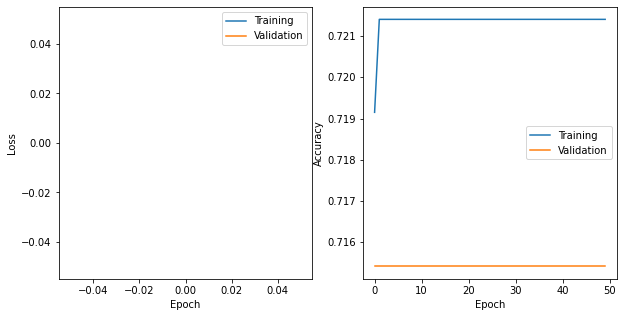

In [49]:
plot_model_history(relu_history)

## Problem E - scaling and Adam optimizer save ReLU

**AUC is 97.49%** and **acc = 92.75%**

The models seem to perform comparatively well, but it's difficult to find the best parameters to optimize without looking at the loss curves. BDT takes less time too. I also had to go a different route (from the hands-on assignment structure) than the previous exercises because with the scaler function all the predictions would turn out to be Nan and I was not able to trouble-shoot it in a reasonable amount of time.

In [69]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
optimizer_s = keras.optimizers.Adam(learning_rate=0.001)

model2 = Sequential(name="sequential")
model2.add(Dense(128, input_shape=X_train.shape[1:], name="fc1"))
model2.add(Activation(activation="relu", name="relu1"))
model2.add(Dense(128, name="fc2"))
model2.add(Activation(activation="relu", name="relu2"))
model2.add(Dense(128, name="fc3"))
model2.add(Activation(activation="relu", name="relu3"))
model2.add(Dense(2, activation="sigmoid", name="output")) 

model2.compile(optimizer=optimizer_s, loss=["binary_crossentropy"], metrics=["accuracy"])
history2 = model2.fit(X_train_s, to_categorical(y_train, 2), epochs=50, batch_size=128, verbose=0, validation_split=0.25)

preds_nn2 = model2.predict(X_test_s)

/Users/ruxi/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


813/813 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


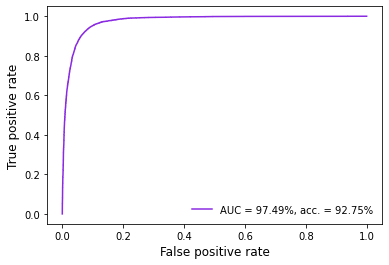

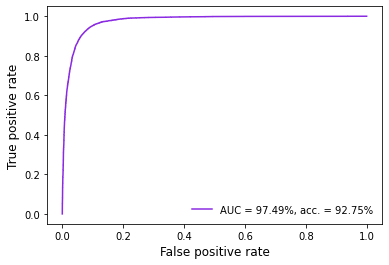

In [70]:
plot_roc(y_test, preds_nn2[:,1])